<a href="https://colab.research.google.com/github/iusami/bayes_ml/blob/master/chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#moduleの準備
!pip install numpyro japanize-matplotlib

     |████████████████████████████████| 264 kB 5.3 MB/s 
     |████████████████████████████████| 4.1 MB 42.0 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=23611bc0763fb276cdf65aa5d128df24ddd245375035b31d89023c8d62458d60
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [2]:
import japanize_matplotlib
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
from jax.random import PRNGKey

In [4]:
key = PRNGKey(seed=1234)

## 一様分布とベータ分布からサンプリング

In [5]:
from numpyro.distributions import Uniform, Beta

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [6]:
uni = Uniform()
beta = Beta(concentration0=4, concentration1=6)

In [7]:
uniform_sample = uni.sample(key, sample_shape=(10000,1))
beta_sample = beta.sample(key, sample_shape=(10000,1))

In [8]:
np.array(uniform_sample).shape

(10000, 1)

In [9]:
uniform_df = pd.DataFrame({"value":np.array(uniform_sample).reshape(-1), "kind":"uniform"})
beta_df = pd.DataFrame({"value":np.array(beta_sample).reshape(-1), "kind":"beta"})
sample_df = pd.concat([uniform_df, beta_df], axis=0).reset_index(drop=True)

In [10]:
sample_df

,value,kind
0,0.355426,uniform
1,0.502301,uniform
2,0.506489,uniform
3,0.862560,uniform
4,0.383682,uniform
...,...,...
19995,0.298222,beta
19996,0.805361,beta
19997,0.730739,beta
19998,0.651273,beta


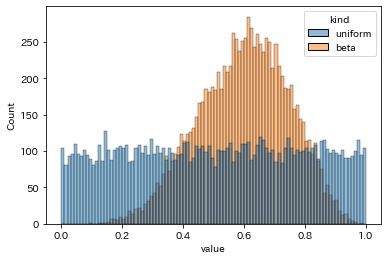

In [11]:
sns.histplot(data=sample_df,x="value", hue="kind", bins=100,binrange=(0,1),)

## ベータ分布の事後分布の計算

データがベルヌーイ分布から生成されたとして、事前分布をベータ分布
$$p(x|\alpha,\beta) = \cfrac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha,\beta)}$$
とする。  
その時事後分布は以下のようにかける。

$$p(q|D) = \cfrac{q^{\alpha_\ast-1}(1-q)^{\beta_\ast-1}}{B(\alpha_\ast,\  \beta_\ast)}, \alpha_\ast=y+\alpha, \beta_\ast=n-y+\beta, y=\sum_{i=1}^{n}x_i   $$ 
ただし、$n$はサンプルサイズ。

In [17]:
from numpyro.distributions import BernoulliProbs

In [19]:
bern = BernoulliProbs(0.25)

In [26]:
#データの準備
n = [10,50,250]
bern_sample = [bern.sample(key, sample_shape=(i,1)) for i in n]

In [27]:
def beta_posterior_parameter(alpha, beta, sample):
  y = np.sum(sample)
  alpha_ast = y + alpha
  beta_ast = len(sample) - y + beta
  return alpha_ast, beta_ast

In [30]:
alpha0=1
beta0=1

In [35]:
post_params = [beta_posterior_parameter(alpha0, beta0, np.array(i)) for i in bern_sample]

In [36]:
post_params

[(1, 11), (6, 46), (62, 190)]

In [41]:
beta_posterior_samples = []
for ct, params in enumerate(post_params):
  alpha_curr, beta_curr = params
  beta_post = Beta(alpha_curr, beta_curr)
  sample_df_tmp = pd.DataFrame({"value":np.array(beta_post.sample(key, sample_shape=(10000,1)).reshape(-1)), "kind":"params{}".format(str(ct))})
  beta_posterior_samples.append(sample_df_tmp)
beta_posterior_samples_df = pd.concat(beta_posterior_samples).reset_index(drop=True)

In [42]:
beta_posterior_samples_df

,value,kind
0,0.170068,params0
1,0.219015,params0
2,0.038690,params0
3,0.220163,params0
4,0.024913,params0
...,...,...
29995,0.205904,params2
29996,0.285823,params2
29997,0.284597,params2
29998,0.234279,params2


In [48]:
#事前分布のサンプル
beta_pre = Beta(alpha0, beta0)
beta_pre_sample = np.array(beta_pre.sample(key, sample_shape=(10000,1))).reshape(-1)
beta_pre_sample_df = pd.DataFrame({"value":beta_pre_sample,"kind":"pre"})

In [49]:
beta_pre_sample_df

,value,kind
0,0.864801,pre
1,0.551698,pre
2,0.567245,pre
3,0.766960,pre
4,0.179633,pre
...,...,...
9995,0.006027,pre
9996,0.792740,pre
9997,0.798679,pre
9998,0.872559,pre


In [50]:
concat_df = pd.concat([beta_posterior_samples_df, beta_pre_sample_df]).reset_index(drop=True)

In [51]:
concat_df

,value,kind
0,0.170068,params0
1,0.219015,params0
2,0.038690,params0
3,0.220163,params0
4,0.024913,params0
...,...,...
39995,0.006027,pre
39996,0.792740,pre
39997,0.798679,pre
39998,0.872559,pre


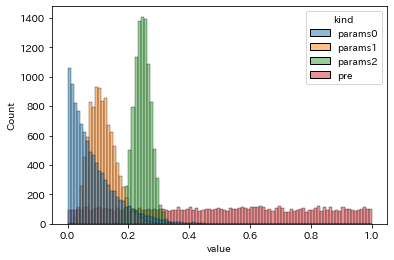

In [54]:
sns.histplot(concat_df, x="value", hue="kind", bins=100,binrange=(0,1))

In [55]:
#事前分布の変更

In [56]:
alpha1=6
beta1=4

In [62]:
post_params = [beta_posterior_parameter(alpha1, beta1, np.array(i)) for i in bern_sample]

In [63]:
post_params

[(6, 14), (11, 49), (67, 193)]

In [64]:
beta_posterior_samples = []
for ct, params in enumerate(post_params):
  alpha_curr, beta_curr = params
  beta_post = Beta(alpha_curr, beta_curr)
  sample_df_tmp = pd.DataFrame({"value":np.array(beta_post.sample(key, sample_shape=(10000,1)).reshape(-1)), "kind":"params{}".format(str(ct))})
  beta_posterior_samples.append(sample_df_tmp)
beta_posterior_samples_df = pd.concat(beta_posterior_samples).reset_index(drop=True)

In [65]:
beta_posterior_samples_df

,value,kind
0,0.364369,params0
1,0.442736,params0
2,0.277799,params0
3,0.405841,params0
4,0.232902,params0
...,...,...
29995,0.217932,params2
29996,0.297894,params2
29997,0.295758,params2
29998,0.245686,params2


In [66]:
#事前分布のサンプル
beta_pre = Beta(alpha1, beta1)
beta_pre_sample = np.array(beta_pre.sample(key, sample_shape=(10000,1))).reshape(-1)
beta_pre_sample_df = pd.DataFrame({"value":beta_pre_sample,"kind":"pre"})

In [67]:
beta_pre_sample_df

,value,kind
0,0.703761,pre
1,0.666226,pre
2,0.633386,pre
3,0.703414,pre
4,0.493859,pre
...,...,...
9995,0.298222,pre
9996,0.805361,pre
9997,0.730739,pre
9998,0.651273,pre


In [68]:
concat_df_2 = pd.concat([beta_posterior_samples_df, beta_pre_sample_df]).reset_index(drop=True)

In [69]:
concat_df_2

,value,kind
0,0.364369,params0
1,0.442736,params0
2,0.277799,params0
3,0.405841,params0
4,0.232902,params0
...,...,...
39995,0.298222,pre
39996,0.805361,pre
39997,0.730739,pre
39998,0.651273,pre


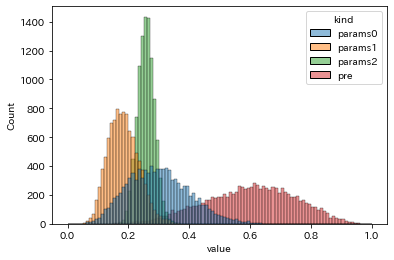

In [70]:
sns.histplot(concat_df_2, x="value", hue="kind", bins=100,binrange=(0,1))

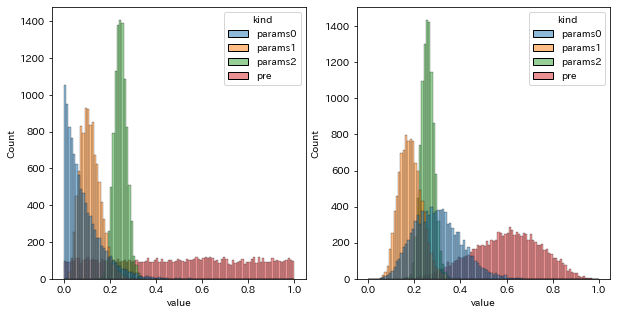

In [71]:
#事前分布の影響の比較
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.histplot(concat_df, x="value", hue="kind", bins=100,binrange=(0,1), ax=ax[0])
sns.histplot(concat_df_2, x="value", hue="kind", bins=100,binrange=(0,1), ax=ax[1])

In [72]:
#HPD区間の表示

In [73]:
from numpyro.diagnostics import summary

In [81]:
beta_pre_sample = beta_pre.sample(key, sample_shape=(10000,1))

In [83]:
summary_res = summary(beta_pre_sample,group_by_chain=False)

In [111]:
summary_res

{'Param:0': OrderedDict([('mean', array([0.59987605], dtype=float32)),
              ('std', array([0.14782001], dtype=float32)),
              ('median', array([0.60853326], dtype=float32)),
              ('5.0%', array([0.36574516], dtype=float32)),
              ('95.0%', array([0.8501521], dtype=float32)),
              ('n_eff', array([9889.899877])),
              ('r_hat', array([0.9999139], dtype=float32))])}

In [87]:
summary_res["Param:0"]["5.0%"]

array([0.36574516], dtype=float32)

(0.0, 1500.0)

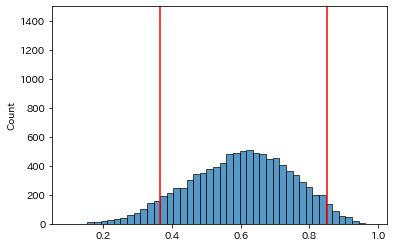

In [91]:
sns.histplot(np.array(beta_pre_sample).reshape(-1))
plt.vlines(summary_res["Param:0"]["5.0%"],0,10000,color="red")
plt.vlines(summary_res["Param:0"]["95.0%"],0,10000,color="red")
plt.ylim(0,1500)

In [112]:
#事後分布についてのsummary

In [113]:
post_beta_summary = Beta(post_params[2][0], post_params[2][1])

In [114]:
post_beta_summary_sample = post_beta_summary.sample(key, (10000,1))
summary(post_beta_summary_sample,0.9,False)

{'Param:0': OrderedDict([('mean', array([0.2577526], dtype=float32)),
              ('std', array([0.02713515], dtype=float32)),
              ('median', array([0.25745842], dtype=float32)),
              ('5.0%', array([0.21162954], dtype=float32)),
              ('95.0%', array([0.30036533], dtype=float32)),
              ('n_eff', array([9944.38710195])),
              ('r_hat', array([1.0000194], dtype=float32))])}

In [92]:
#事後確率の計算

In [96]:
beta_post = Beta(post_params[2][0],post_params[2][1])

In [101]:
1 - beta_post.cdf(0.2)

DeviceArray(0.9870108, dtype=float32, weak_type=True)

In [102]:
#事後オッズ比の計算

In [104]:
#0.2%以上であるという仮説
odds = (1 - beta_post.cdf(0.2))/beta_post.cdf(0.2)
odds

DeviceArray(75.98674, dtype=float32, weak_type=True)

In [105]:
#ベイズファクターでの比較

In [106]:
pre_odds = (1- beta_pre.cdf(0.2))/beta_pre.cdf(0.2)

In [107]:
np.log10(odds/pre_odds)

-0.6313052

In [108]:
#確率変数の予測

In [110]:
a_ast, b_ast = post_params[2]
a_ast/(a_ast+b_ast)

0.25769230769230766